In [1]:
__author__ = 'BENALI Fodil'
__email__ = 'fodel.benali@gmail.com'
__copyright__ = 'Copyright (c) 2023, Technical Test'

import sys

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

from scipy import stats
import itertools
import math

from scipy.stats import ks_2samp
from scipy.stats import ttest_ind

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# Check python version
print(sys.version)

3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]


# Question 1 : Data Description 

In [3]:
# Data Preparation class
class DataPreprocessor:
    
    # Load data from a CSV File
    def load_data(self, filepath):
        return pd.read_csv(filepath)
    
    # Get Details about Data
    def get_data_details(self, df):
    
        # Get number of columns to have idea about dimensionality to choose the most appropriate algorithms
        print(f"Number of Columns:{df.shape[1]}, number of observations: {df.shape[0]} \n")

        categorial_features = []

        numerical_features = []

        other_features = []

        if ((df.shape[0]>0) & (df.shape[1]>0)):

            # Get the data types of the columns
            column_types = df.dtypes

            # Print the column names, data types, proportion of nan values in order to define the most adequate cleaning pipeline
            for col, col_type in column_types.items():

                print(f"Column: {col}, Type: {col_type}, Proportion of Nan values: {round(df[col].isna().sum()/df.shape[0],3)}%")

                if col_type == 'object':
                    categorial_features.append(col)

                elif col_type in [np.int64, np.float64]:
                    numerical_features.append(col)

                else: 
                    other_features.append(col)

            print(f"\n{len(categorial_features)} Categorical Features: {categorial_features}, \
                  \n\n{len(numerical_features)} Numerical Features: {numerical_features},\
                  \n\n{len(other_features)} Other Features: {other_features} \n ")

        return categorial_features, numerical_features, other_features

    def remove_columns(self, data, to_drop):
        
        # Drop Duplicates Columns
        print(f'--------- . Drop Useless Columns: {to_drop}')
        data.drop(columns=to_drop, inplace=True)


    def clean_data(self, data):
        
        # Trim whitespace from strings
        print('--------- . Trim whitespace from strings')
        data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

        # Drop Duplicates Rows
        print('--------- . Drop Duplicates Rows')
        data.drop_duplicates(inplace=True)

        # Remove rows with missing values : 
        # We have noticed that there is not a lot of missing values, for that we prefer remove its from the dataset
        print('--------- . Remove rows with missing values')
        data.dropna(inplace=True)
        
        return data
        
        
    
data_preprocessor = DataPreprocessor() 

# Data Preparation

In [4]:
print('------------------------------------------ Data structure ---------------------------------------------- \n')

# Load the data
file_path = './data.csv'
data = data_preprocessor.load_data(file_path)
print(data.head)


print('\n --------------------------------------------- Data Description ------------------------------------------------- \n')          
# To get infos about  columns
categorial_features, numerical_featues, other_features = data_preprocessor.get_data_details(data)   


print('\n --------------------------------------------- Data Cleaning ---------------------------------------------\n')

# Convert columns to the correct data type
print('--------- . Convert Data To Correct Data Type')

#  Using errors=’coerce’. It will replace all non-numeric values with NaN/Nat
data["age"] = pd.to_numeric(data["age"], downcast='integer', errors='coerce')
data["exp"] = pd.to_numeric(data["exp"], downcast='integer', errors='coerce')
data["date"] = pd.to_datetime(data["date"], format='%Y-%m-%d', errors='coerce')

# Filter incoherent data:
print('--------- . Filter incoherent data (e.g., age < 16, experience<0, note > 100)')
# You can't graduate before age 16, with a few exceptions,
# you can't have negative experience and a grade above 100
data = data[(data["age"]>=16) & (data["exp"]>=0) & (data["note"]<=100) & (data["note"]>=0)]


# Drop Useless Columns: Unnamed: 0, index: Duplicated 
#'cheveux': Discrimination based on physical appearance Not allowed in France, but we will keep it for analysis

to_drop = ['Unnamed: 0', 'index']
data_preprocessor.remove_columns(data, to_drop)

data = data_preprocessor.clean_data(data)


print('\n --------------------------------------------- Data After Cleaning -----------------------------------------------------\n')
categorical_features, numerical_featues, other_features = data_preprocessor.get_data_details(data)

------------------------------------------ Data structure ---------------------------------------------- 

<bound method NDFrame.head of        Unnamed: 0  index        date  cheveux   age   exp  salaire sexe  \
0               0      0  2012-06-02     roux  25.0   9.0  26803.0    F   
1               1      1  2011-04-21    blond  35.0  13.0  38166.0    M   
2               2      2  2012-09-07    blond  29.0  13.0  35207.0    M   
3               3      3  2011-07-01     brun   NaN  12.0  32442.0    M   
4               4      4  2012-08-07     roux  35.0   6.0  28533.0    F   
...           ...    ...         ...      ...   ...   ...      ...  ...   
19995       19995  19995  2012-03-10     roux  47.0   9.0  35723.0    M   
19996       19996  19996  2010-09-19  chatain  38.0  10.0  33570.0    F   
19997       19997  19997  2010-09-02  chatain  23.0   6.0  33751.0    F   
19998       19998  19998  2011-12-06  chatain  33.0  11.0  34167.0    F   
19999       19999  19999  2010-11-29  

# Data Exploration

In [5]:
class DataExplorator:
    
    def dependent_variable_proportions(self, data, dependent_variable= 'embauche'):
        
        sns.countplot(x=dependent_variable, data=data, palette='hls').set_title('Proportion d\'embauche')

        plt.show()
        
        proportion = data[dependent_variable].sum()/data.shape[0]
        
        print(f"Pourcentage d'embauche : {proportion* 100:.2f} %\n")
        
        return proportion
    
    def feature_proportions_per_dependent_variable(self, data, feature, dependent_variable= 'embauche'):
        
        ax = sns.countplot(x=feature, data=data, palette='hls', hue=dependent_variable).set_title(f'Proportion d\'embauche par {feature}')
            
        plt.show()
    
        freq = {}

        for label in data[feature].unique():
            
            freq[label] = str(round(100 * data[feature][(data[feature] == label) & (data[dependent_variable] == 1)].count()/data[feature][data[feature] == label].count(), 3))+ ' %'
    
        print(f'Hiring Proportion per category:{freq}\n')
        
    
    def feature_distribution_per_dependent_variable(self, data, feature, dependent_variable='embauche'):
        
        ax = sns.displot(data=data, x=feature, hue = dependent_variable, kind="kde")

        ax.figure.suptitle(f'Distribution of hiring per obtained {feature}')

        plt.show()
        
    
data_explorator = DataExplorator()   

<div class="alert alert-block alert-info">
The <b>Chi-Squared test</b> is a statistical test used to assess the statistical significance of the association between two categorical variables. It is based on the Chi-Squared statistic, which measures the difference between the observed frequencies and the expected frequencies in the contingency table. The Chi-Squared test is commonly used to determine whether there is a significant association between two categorical variables. 
    
If the p-value is small (typically less than 0.05), it indicates that the observed frequencies are significantly different from the expected frequencies, and therefore there is a significant association between the two variables. If the p-value is large, it indicates that the observed frequencies are not significantly different from the expected frequencies, and therefore there is no significant association between the variables.
</div>

<div class="alert alert-block alert-info">
    The <b>T-test</b> is a statistical test used to determine whether there is a significant difference between the means of two groups. It is commonly used to compare the means of two populations. The paired t-test is used to compare the means of two related samples, such as the scores of the same group of people on two different tests. It is used to test the hypothesis that the mean difference between the two tests is zero.

To perform a t-test, you need to compute the t-statistic, which is a measure of the difference between the means of the two groups. The t-statistic is calculated as the difference between the means divided by the standard error of the difference. The p-value of the t-test is the probability of obtaining a t-statistic at least as large as the observed value, given that the null hypothesis (no difference between the means) is true.

If the p-value is small (typically less than 0.05), it indicates that the observed difference between the means is statistically significant, and therefore there is a significant difference between the two groups. If the p-value is large, it indicates that the observed difference is not statistically significant, and therefore there is no significant difference between the groups.
</div>

<div class="alert alert-block alert-info">
<b>ANOVA (Analysis of Variance)</b> is a statistical test used to determine whether there is a significant difference between the means of two or more groups. It is used to compare the means of multiple groups, and to test the hypothesis that the means of the groups are equal. If the p-value is small (typically less than 0.05), it indicates that the observed difference between the means is statistically significant, and therefore there is a significant difference between the groups. If the p-value is large, it indicates that the observed difference is not statistically significant, and therefore there is no significant difference between the groups.
    
- One-way ANOVA is a statistical test that can be used to evaluate the dependence between a categorical and a continuous variable. The categorical variable is often referred to as the independent variable, while the continuous variable is referred to as the dependent variable.

- One-way ANOVA is used to test the null hypothesis that the means of the dependent variable are equal across all levels of the independent variable. If the null hypothesis is rejected, it suggests that there is a significant difference in the means of the dependent variable between at least two levels of the independent variable, indicating a dependence between the two variables.

- One-way ANOVA is an appropriate test to use when you have one categorical independent variable and a continuous dependent variable, and you want to test whether the mean of the dependent variable is the same across all levels of the independent variable.
</div>

In [6]:
class HypothesisTestEvaluation:

    # Evaluate  association between pair of variables using Chi2 test  
    def chi2_test(self, data, col1, col2="embauche"):

        # Create a contingency table
        cont_table = pd.crosstab(data[col1], data[col2])

        # Perform the chi-square test
        chi2, p, dof, ex = chi2_contingency(cont_table)
        
        #p = round(p, 8)

        # Determine the test result
        if p < 0.05:
            print(f"p-value={p} < 0.05 ==>  Significant Dependence using Chi2 Test")
        else:
            print(f"p-value={p} >= 0.05 ==> No Significant Dependence using Chi2 Test")
            
    
    # Compare distribution using two-sample Kolmogorov-Smirnov test        
    def compare_distribution_using_ks_test(self, data, col1, col2="embauche"):
        
        statistic, p =  ks_2samp(data[data[col2]==1][col1].values, data[data[col2]==1][col1].values)
        
        # Determine the test result
        if p < 0.05:
            print(f"p-value={p} < 0.05 ==>  Significant Dependence using Chi2 Test (significant difference between distributions)")
        else:
            print(f"p-value={p} >= 0.05 ==> No Significant Dependence using two-sample Kolmogorov-Smirnov test (same distribution)")
        
        
    # Compare distribution using  two-sample t-test        
    def compare_distribution_using_tt_test(self, data, col1, col2="embauche"):   

        stat, p = ttest_ind(data[data[col2]==1][col1].values, data[data[col2]==1][col1].values)
        
        # Determine the test result
        if p < 0.05:
            print(f"p-value={p} < 0.05 ==>  Significant Dependence using T Test (significant difference between distributions means)")
        else:
            print(f"p-value={p} >= 0.05 ==> No Significant Dependence using T test (no significant difference between distributions means)")
    
    
    def assess_dependence_using_anova_test(self, data, cat_col, cont_col):
    
        # Group the continuous column by the categorical column
        grouped_df = data.groupby(cat_col)[cont_col]

        # Perform the one-way ANOVA test
        statistic, pvalue = f_oneway(*[grouped_df.get_group(x) for x in grouped_df.groups])
        
        p = pvalue

        # Determine the test result
        if p < 0.05:
            print(f"p-value={p} < 0.05 ==>  Significant Dependence using Anova one way Test")
        else:
            print(f"p-value={p} >= 0.05 ==> No Significant Dependence using Anova one way Test")
            
hypothesis_test_evaluation = HypothesisTestEvaluation()

 ----------------------------------------------- Data Exploration -----------------------------------------------------


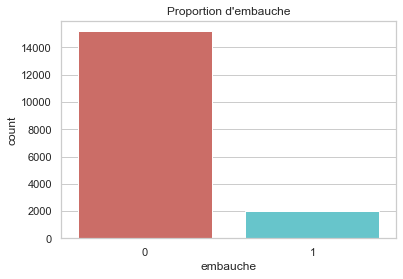

Pourcentage d'embauche : 11.64 %

----------------- Conclusion: Data set is unbalanced ----------------------


In [7]:
print(' ----------------------------------------------- Data Exploration -----------------------------------------------------')

dependent_variable = 'embauche'

proportion = data_explorator.dependent_variable_proportions(data)

if(proportion < 0.5):

    print("----------------- Conclusion: Data set is unbalanced ----------------------")

Dependence Evaluation between: ['cheveux', 'sexe', 'diplome', 'specialite', 'dispo'] and the dependent feature: embauche


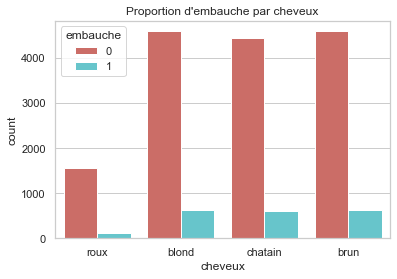

Hiring Proportion per category:{'roux': '7.053 %', 'blond': '12.175 %', 'chatain': '12.051 %', 'brun': '12.184 %'}

p-value=2.817883450303054e-08 < 0.05 ==>  Significant Dependence using Chi2 Test


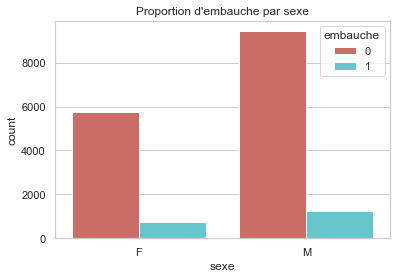

Hiring Proportion per category:{'F': '11.512 %', 'M': '11.723 %'}

p-value=0.6936739461846821 >= 0.05 ==> No Significant Dependence using Chi2 Test


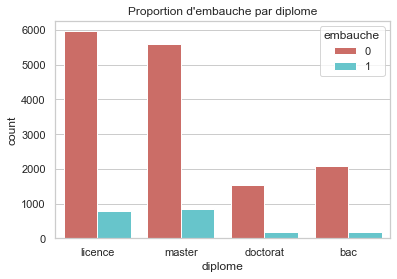

Hiring Proportion per category:{'licence': '11.699 %', 'master': '13.109 %', 'doctorat': '11.22 %', 'bac': '7.631 %'}

p-value=1.1529541881237055e-10 < 0.05 ==>  Significant Dependence using Chi2 Test


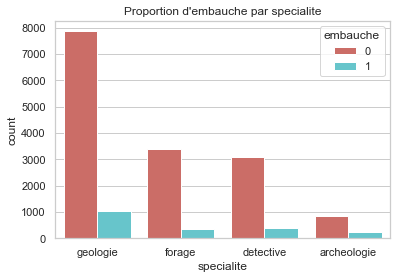

Hiring Proportion per category:{'geologie': '11.621 %', 'forage': '9.543 %', 'detective': '10.732 %', 'archeologie': '21.838 %'}

p-value=5.766819265444482e-28 < 0.05 ==>  Significant Dependence using Chi2 Test


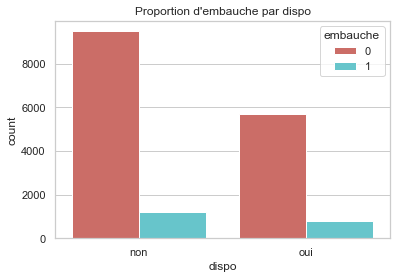

Hiring Proportion per category:{'non': '11.395 %', 'oui': '12.052 %'}

p-value=0.20139853226042273 >= 0.05 ==> No Significant Dependence using Chi2 Test


In [8]:
print(f'Dependence Evaluation between: {categorical_features} and the dependent feature: {dependent_variable}')

for feature in categorical_features:

    data_explorator.feature_proportions_per_dependent_variable(data, feature)
    
    hypothesis_test_evaluation.chi2_test(data, feature)

#### From these figures, we notice:
<div class="alert alert-block alert-success">
 
 - There is <b>not a significant difference in the proportion of hires by gender and availability</b>.
    
 - For the rest of the features, there are a significant differences.
 
 => These findings have been validated by the chi2 dependency test.

Therefore, we can assume that there is not enough evidence to consider the gender and availability features as relevant during the hiring process.

In the following, we will test some hypotheses that are often made during the recruitment process:
 - Are applicants with high grades more likely to be hired?
 - Are candidates with more experience more favorable during the recruitment process?
 - Can age be a criterion for selecting a candidate?
 - Does the year, month, season (e.g., heat in the summer, rain in the winter) impact the hiring process? 
</div>

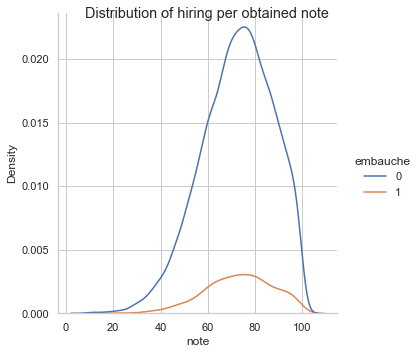

p-value=1.0 >= 0.05 ==> No Significant Dependence using T test (no significant difference between distributions means)


In [9]:
data_explorator.feature_distribution_per_dependent_variable(data, "note")
hypothesis_test_evaluation.compare_distribution_using_tt_test(data,"note")

<div class="alert alert-block alert-success">
From the figure we can see that there are several candidates who had very good grades but were not hired. Therefore, <b>this may indicate that having very good grades is not enough to succeed in a recruitment process. This finding have been validated using the T-Test.</b>
 </div>

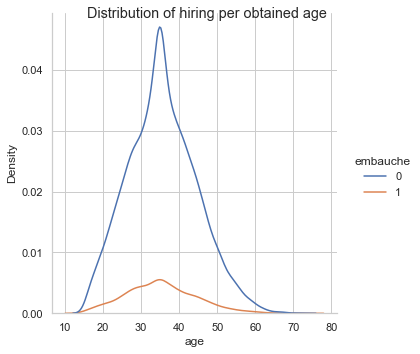

p-value=0.10822118583354262 >= 0.05 ==> No Significant Dependence using Chi2 Test


In [10]:
data_explorator.feature_distribution_per_dependent_variable(data, "age")
hypothesis_test_evaluation.chi2_test(data,"age")

<div class="alert alert-block alert-success">
From the figure we can see that there are several candidates who had same age but were not hired. Therefore, <b>this may indicate that the age alone is not a decisive creterion in a recruitment process. This finding have been validated using the Chi2-Test which compares the two distribution.</b>
 </div>

---------------------------------  Extract Features from date attribute -----------------------------------------------


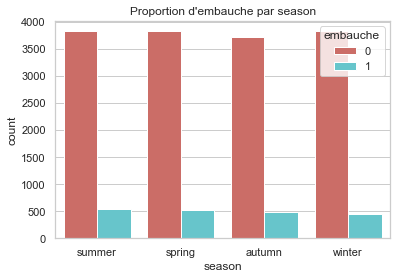

Hiring Proportion per category:{'summer': '12.271 %', 'spring': '12.061 %', 'autumn': '11.553 %', 'winter': '10.668 %'}

p-value=0.09358378576984065 >= 0.05 ==> No Significant Dependence using Chi2 Test


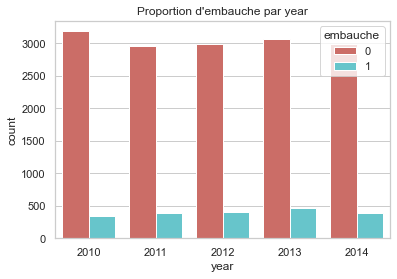

Hiring Proportion per category:{2012: '12.132 %', 2011: '11.443 %', 2014: '11.699 %', 2013: '13.077 %', 2010: '9.875 %'}

p-value=0.0008917087873327919 < 0.05 ==>  Significant Dependence using Chi2 Test


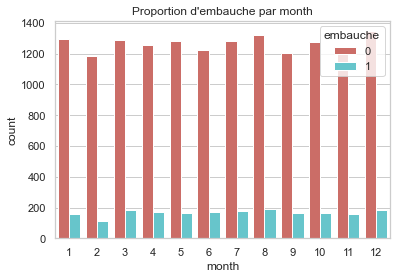

Hiring Proportion per category:{6: '12.123 %', 4: '12.008 %', 9: '11.877 %', 8: '12.574 %', 2: '8.846 %', 11: '11.508 %', 3: '12.652 %', 10: '11.289 %', 7: '12.096 %', 5: '11.509 %', 1: '10.92 %', 12: '11.976 %'}

p-value=0.2009517832844671 >= 0.05 ==> No Significant Dependence using Chi2 Test


In [11]:
# # Extract features from date attributes: Month, Year, Season
print('---------------------------------  Extract Features from date attribute -----------------------------------------------')

data["month"] = data["date"].dt.month.astype('category')

data["year"] = data["date"].dt.year.astype('category')

# Create a new column with the saison to characterize the period of hiring the most important
data["season"] = "Unknown"
data.loc[data["month"].isin([12, 1, 2]), "season"] = "winter"
data.loc[data["month"].isin([3, 4, 5]), "season"] = "spring"
data.loc[data["month"].isin([6, 7, 8]), "season"] = "summer"
data.loc[data["month"].isin([9, 10, 11]), "season"] = "autumn"
data["season"].astype('category')

date_features = ['season', 'year', 'month']

for feature in date_features:
    
    data_explorator.feature_proportions_per_dependent_variable(data, feature)
    
    hypothesis_test_evaluation.chi2_test(data, feature)


<div class="alert alert-block alert-success">
From these figures and results, we notice that there <b>is no significant difference in the proportions of hiring by season and month</b>. In conclusion, this may lead us to discard date modeling in the recruitment process.
</div>

# Question 2 : Statistical Tests

In [12]:
# Pour répondre à la premiere question on utilise Chi2 Test
hypothesis_test_evaluation.chi2_test(data, "sexe", "specialite")

p-value=0.0 < 0.05 ==>  Significant Dependence using Chi2 Test


<div class="alert alert-block alert-success">
Since the p-value is less than a significant level of 0.05, then we can reject the hypothesis that the two columns are independent and we can conclude that <b>the two features specialty and sex present a significant level of dependence</b>.
</div>

In [13]:
cat_col = 'cheveux'
cont_col = 'salaire'
hypothesis_test_evaluation.assess_dependence_using_anova_test(data, cat_col, cont_col)

p-value=5.624715091556883e-28 < 0.05 ==>  Significant Dependence using Anova one way Test


<div class="alert alert-block alert-success">
The null hypothesis of the ANOVA test is that the means of the continuous variable are equal in the different categories of the categorical variable. Since the P-value obtained by the ANOVA test is less than 0.05, we can reject the null hypothesis and conclude that the means are significantly different, indicating that there is <b>a significant dependence between the hair variable and the wage variable</b>.
</div>

In [14]:
cat_col = "exp"
cont_col = "note"

hypothesis_test_evaluation.assess_dependence_using_anova_test(data, cat_col, cont_col)

p-value=0.17621223498289212 >= 0.05 ==> No Significant Dependence using Anova one way Test


<div class="alert alert-block alert-success">
The null hypothesis of the ANOVA test is that the means of the continuous variable are equal in the different categories of the categorical variable. Since the P-value obtained by the ANOVA test is greater than 0.05, we cannot reject the null hypothesis and conclude that the means are significantly different, which indicates that there is <b>no significant dependence between the experience feature and the score feature</b>.
</div>

# Question 3 : Model Fitting

### 1. Filter unuseful data

In [15]:
data.columns

Index(['date', 'cheveux', 'age', 'exp', 'salaire', 'sexe', 'diplome',
       'specialite', 'note', 'dispo', 'embauche', 'month', 'year', 'season'],
      dtype='object')

<div class="alert alert-block alert-success">
As there is no significant dependency between each of these variables ['date', 'month', 'sex', 'availability', 'season', 'year'] and the variable we want to predict (hiring). So I chose to omit them in my proposal.
</div>

In [16]:
to_drop = ['date', 'month', 'sexe', 'dispo', 'season', 'year']
data.drop(columns=to_drop, inplace=True) 

### 2. Encode Categorical data

<div class="alert alert-block alert-success">
In order to use the categorical variables in our models, we need to transform them: There are two types of categorical data: <b>Nominal and Ordinal</b>. For nominal variables, we will transform them using one hot encoding and for ordinal variables, we will use the label Encoding.
</div>

<div class="alert alert-block alert-info">
<b>One hot encoding</b> is a way to represent categorical variables as numerical data. It involves creating a new column for each unique category in a categorical variable. Each row is then marked with a 1 in the column for the corresponding category and 0 in all other new columns.
</div>

<div class="alert alert-block alert-info">
<b>Label encoding</b> is a way to represent categorical variables as numerical data. It involves assigning a unique integer value to each category and then encoding the categories as integers. One potential issue with label encoding is that it can imply an ordinal relationship between the categories, where in reality there may not be one.
</div>

In [17]:
from sklearn import preprocessing


class FeaturesEncoders:

    def one_hot_encoding(self, data, one_hot_encoding_vars):

        for categorical_var in one_hot_encoding_vars:
            # One hot encode the variable
            one_hot_encoded = pd.get_dummies(data[categorical_var], drop_first=True)

            # Concatenate the encoded variable with the original dataset
            data = pd.concat([data, one_hot_encoded], axis=1)

            # Drop the original categorical variable
            data = data.drop(categorical_var, axis=1)

        return data

    def label_encoding_1(self, data, label_encoding_vars):

        for categorical_var in label_encoding_vars:
            # Create a label encoder
            le = preprocessing.LabelEncoder()

            # Fit the label encoder to the categorical variable
            le.fit(data[categorical_var])

            # Transform the categorical variable and store the encoded values in a new column
            data[categorical_var] = le.transform(data[categorical_var])

        return data

    # Manual Label Encoding for ordinal variables
    def label_encoding_2(self, data, feature, encoding_dic):    

        data[feature].replace(encoding_dic, inplace=True)

        return data  

In [18]:
one_hot_encoding_vars = ['cheveux', 'specialite']

label_encoding_vars = ['diplome']

features_encoders = FeaturesEncoders()

data = features_encoders.one_hot_encoding(data, one_hot_encoding_vars)

# We have an order between the different categories of the variable diploma, for this, we must make the encoding manually 
data = features_encoders.label_encoding_2(data,'diplome', {"bac":1, "licence":2, 'master':3, 'doctorat':4})

In [19]:
features = [col for col in data.columns if col !="embauche"]
data[features]

,age,exp,salaire,diplome,note,brun,chatain,roux,detective,forage,geologie
0,25.0,9.0,26803.0,2,97.08,0,0,1,0,0,1
1,35.0,13.0,38166.0,2,63.86,0,0,0,0,1,0
2,29.0,13.0,35207.0,2,78.50,0,0,0,0,0,1
4,35.0,6.0,28533.0,2,81.91,0,0,1,1,0,0
5,37.0,8.0,38558.0,3,63.46,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
19994,33.0,9.0,32674.0,2,65.23,0,0,0,0,0,1
19995,47.0,9.0,35723.0,2,66.47,0,0,1,0,0,1
19996,38.0,10.0,33570.0,3,62.29,0,1,0,0,0,1
19998,33.0,11.0,34167.0,2,73.35,0,1,0,1,0,0


### 3. Model Choice

<div class="alert alert-block alert-info">
It is well known that tree-based algorithms : <b>Decision trees, random forests, and gradient boosting are all commonly used algorithms for classification tasks, and they are generally able to handle unbalanced data well</b>. These algorithms create a hierarchy of decision rules, which can be effective in identifying patterns in the data, even if the classes are unbalanced. In what follows, we will verify these assumptions by testing different algorithms with default configurations.
</div>

In [20]:
class ModelFitter:

    def __init__(self, data, depedent_variable="embauche", test_size=0.1, random_state=42):

        data = data.reset_index(drop=True)

        features = [col for col in data.columns if col !=depedent_variable]

        X = data[features]

        y = data[depedent_variable]
        
        self.predictions = {}

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    def fit(self, model):

        model_name = type(model).__name__
        
        model.fit(self.X_train, self.y_train)
        
        self.predictions[model_name] = model.predict(self.X_test)

    def evaluate(self):

        comparison_table = [['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']]
        
        for model in self.predictions.keys():
            pred = self.predictions[model]
            model_scores = [model, round(accuracy_score(self.y_test, pred),4), \
                            round(precision_score(self.y_test, pred),4), \
                            round(recall_score(self.y_test, pred),4), \
                            round(f1_score(self.y_test, pred),4)]
            comparison_table.append(model_scores)

        for line in comparison_table:
            print(f'{line[0]:<25}', end='')
            for ele in line[1:]:
                print(f'{ele:<15}', end='')
            print()

In [21]:
model_fitter = ModelFitter(data)

classifiers = [LogisticRegression(), SGDClassifier(), DecisionTreeClassifier(), \
                       RandomForestClassifier(), GradientBoostingClassifier(), XGBClassifier()]

for classifier in classifiers:
    model_fitter.fit(classifier)
    
model_fitter.evaluate()

Model                    Accuracy       Precision      Recall         F1-score       
LogisticRegression       0.8953         0.0            0.0            0.0            
SGDClassifier            0.8953         0.0            0.0            0.0            
DecisionTreeClassifier   0.8605         0.3469         0.3778         0.3617         
RandomForestClassifier   0.9157         0.7215         0.3167         0.4402         
GradientBoostingClassifier0.9058         0.875          0.1167         0.2059         
XGBClassifier            0.9186         0.75           0.3333         0.4615         


C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<div class="alert alert-block alert-success">
From these results, we notice that we have good results in term of accuracy, but bad for the rest, especially the F1-Score. Howver, as the accuracy is misleading in this case because the data are not balanced. Therefore, we used other metrics such as:
    
- Precesion: the precision is the number of true positive predictions made by the model, divided by the total number of positive predictions made by the model. Precision is a good metric to use when the negative class is more prevalent, as it gives more weight to the correct identification of the minority class. In fact, in an unbalanced data set where the negative class is more prevalent, the classifier may be more likely to predict the negative class in order to achieve higher overall accuracy. However, this may lead to low accuracy, as there may be a high number of false positive predictions (negative instances that are incorrectly classified as positive). By using precision as a performance measure, we can ensure that the model is evaluated on its ability to correctly identify the positive class, rather than on its overall precision. 

- Recall: Recall is the number of true positive predictions made by the model, divided by the total number of true positive instances in the data. Recall is a good metric to use when the positive class is rarer, as it will give more weight to correctly identifying the minority class.

- F1 Score: The F1 score is the harmonic mean of precision and recall, and is a good metric to use when you want to balance precision and recall.

In the following, we will present some suggestions to improve it:
- Balancing the data using undersampling (oversampling using nc-SMOTE could be done also)
- Tuning the parameters of the best algorithm (in this case, based on the F1-score, the RFs are the best)
- Use AutoML in order to select the best algorithm with its parameters (will not be done here, since my OS does not support AutoML)
</div>


### 1. Balancing data using undersampling

In [22]:

class DataBalancer:
    
    def under_sampling(self, data, dependent_variable="embauche", random_state=1):

        df_balanced_1 = data[data[dependent_variable] == 1]

        df_balanced_0 = data[data[dependent_variable] == 0].sample(frac=1, random_state=random_state)[:len(df_balanced_1)]

        data_balanced = pd.concat([df_balanced_0, df_balanced_1])

        return data_balanced

data_balancer = DataBalancer()
balanced_data = data_balancer.under_sampling(data)
balanced_data

,age,exp,salaire,diplome,note,embauche,brun,chatain,roux,detective,forage,geologie
14393,39.0,5.0,30748.0,3,87.60,0,0,1,0,0,0,1
11509,33.0,6.0,39564.0,2,51.77,0,0,0,0,1,0,0
998,41.0,6.0,39628.0,3,67.78,0,0,0,0,0,0,1
7697,24.0,10.0,37336.0,3,70.35,0,0,1,0,0,0,1
5668,35.0,16.0,43152.0,2,43.96,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19944,26.0,9.0,39553.0,3,54.29,1,0,1,0,0,0,1
19955,35.0,10.0,33438.0,2,80.21,1,0,0,0,0,1,0
19981,35.0,14.0,31213.0,1,66.79,1,1,0,0,0,0,0
19989,25.0,11.0,40685.0,1,84.22,1,0,0,0,0,0,0


In [23]:
model_fitter = ModelFitter(balanced_data)

classifiers = [LogisticRegression(), SGDClassifier(), DecisionTreeClassifier(), \
                       RandomForestClassifier(), GradientBoostingClassifier(), XGBClassifier()]

for classifier in classifiers:
    model_fitter.fit(classifier)
    
model_fitter.evaluate()

Model                    Accuracy       Precision      Recall         F1-score       
LogisticRegression       0.5062         0.482          0.5632         0.5194         
SGDClassifier            0.5262         0.0            0.0            0.0            
DecisionTreeClassifier   0.6584         0.6305         0.6737         0.6514         
RandomForestClassifier   0.7581         0.7627         0.7105         0.7357         
GradientBoostingClassifier0.7456         0.7245         0.7474         0.7358         
XGBClassifier            0.7257         0.7174         0.6947         0.7059         


C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<div class="alert alert-block alert-success">
We see here that the performance of these classifiers has improved remarkably. Therefore, this confirms the fact that unbalanced data has a significant impact on the learning quality of an ML model. Nevertheless, we are still far from an acceptable prediction quality.
</div>

### 2. Fine tuning Random Forests

<div class="alert alert-block alert-info">
There are several important parameters of a random forest model that can affect its performance:

- <b>n_estimators</b>: This is the number of trees in the forest. A larger number of trees will typically lead to a more accurate model, but at the cost of increased computation time.

- <b>max_depth</b>: This is the maximum depth of the trees in the forest. A larger maximum depth will result in more complex trees, which can lead to overfitting if the trees are allowed to grow too deep.

- <b>min_samples_split</b>: This is the minimum number of samples required to split an internal node in the tree. A larger minimum sample size will result in simpler trees, which can reduce the risk of overfitting.

- <b>min_samples_leaf</b>: This is the minimum number of samples required to be at a leaf node. A larger minimum sample size will result in simpler trees, which can reduce the risk of overfitting.

- <b>max_features</b>: This is the maximum number of features considered when splitting a node in the tree. A larger number of features will result in more complex trees, which can lead to overfitting if the model is allowed to consider too many features.

- <b>class_weight</b>: This is a weighting applied to the classes in the dataset. If the class distribution is imbalanced, adjusting the class weights can help the model to better handle the imbalanced data.

- <b>random_state</b>: This is a seed value used to initialize the random number generator, which is used to randomly select features and samples when building the trees. Setting a fixed random state can be useful for reproducibility of results.
</div>

In [28]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

class_weight = ['balanced', 'balanced_subsample']
# bootstrap: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
bootstrap = [False]

<div class="alert alert-block alert-success">
To fine tune these parameters, we perform a grid search over the specified hyperparameter values using 5-fold cross-validation. 
The GridSearchCV class will fit and evaluate the model for each combination of hyperparameters, 
and the best combination will be chosen based on the model's performance on the validation data.
    
For the sake of simplicity, we use RandomizedSearchCV which is similar to GridSearchCV, but instead of searching over a grid of hyperparameter values, it samples from a distribution of possible hyperparameter values. This can be more efficient than GridSearchCV when the hyperparameter search space is large, because it does not need to evaluate every possible combination of hyperparameters.
</div>

In [29]:
# Define the model
model = RandomForestClassifier(random_state=12)

# Define the hyperparameter grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              #'class_weight':class_weight,
             'bootstrap':bootstrap}

# Create a grid search object
#grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

randomized_rearch_rf = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = 5, 
                               cv = 3, verbose=2,  random_state=12, n_jobs = -1)

model_fitter = ModelFitter(data)

model_fitter.fit(randomized_rearch_rf)
    
model_fitter.evaluate()

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Model                    Accuracy       Precision      Recall         F1-score       
RandomizedSearchCV       0.9192         0.7971         0.3056         0.4418         


In [30]:
randomized_rearch_rf.best_params_

{'n_estimators': 288,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 32,
 'bootstrap': False}

In [31]:
model_fitter_balanced = ModelFitter(balanced_data)

model_fitter_balanced.fit(randomized_rearch_rf)
    
model_fitter_balanced.evaluate()

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Model                    Accuracy       Precision      Recall         F1-score       
RandomizedSearchCV       0.7631         0.7654         0.7211         0.7425         


<div class="alert alert-block alert-success">
To conclude, using both of the data undersampling and parameters tuning have improved considerably the performances. Neverthless, the quality of predictions could be more enhanced if we use an oversampling approach like NC-SMOTE.
</div>